#Questions: What should it cost to build a Garden Suite in Edmonton?

Data set location
https://data.edmonton.ca/Urban-Planning-Economy/General-Building-Permits/24uj-dj8v

Total set= 181,741 permits/rows by 23 columns
Time range: Jan 1, 2009 to July 27, 2022

In [33]:
import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.edmonton.ca", None)



In [34]:
results = client.get("24uj-dj8v", zoning="RF1", building_type="Garden Suite (110)", limit=2000)

In [35]:
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
results_df.head()

,row_id,issue_date,permit_date,year,month_number,job_category,job_description,building_type,work_type,construction_value,...,address,legal_description,zoning,neighbourhood_numberr,neighbourhood,count,latitude,longitude,location,geometry_point
0,8-262280273,2019-09-06T00:00:00.000,2019-09-06T00:00:00.000,2019,9,"Single, Semi-detached & Rowhousing",To construct a Garden Suite.,Garden Suite (110),(01) Building - New,99360,...,8718G - 117 STREET NW,Plan 715HW Blk 24 Lot 16,RF1,5580,WINDSOR PARK,1,53.523739585213185,-113.53298854137547,"{'latitude': '53.523739585213185', 'longitude'...","{'type': 'Point', 'coordinates': [-113.5329885..."
1,3-306664457,2019-09-12T00:00:00.000,2019-09-12T00:00:00.000,2019,9,"Single, Semi-detached & Rowhousing",To construct a Garden Suite with balcony.,Garden Suite (110),(01) Building - New,61755,...,10961G - 158 STREET NW,Plan 642KS Blk 6 Lot 13,RF1,4290,MAYFIELD,1,53.55543570096415,-113.5924743295846,"{'latitude': '53.55543570096415', 'longitude':...","{'type': 'Point', 'coordinates': [-113.5924743..."
2,2-352638708,2020-06-05T00:00:00.000,2020-06-05T00:00:00.000,2020,6,"Single, Semi-detached & Rowhousing",To construct a two-Storey Garden Suite (main f...,Garden Suite (110),(01) Building - New,39000,...,11422G - 77 AVENUE NW,Plan 2064S Blk 2 Lot 7,RF1,5290,MCKERNAN,1,53.513480085405554,-113.52685136993443,"{'latitude': '53.513480085405554', 'longitude'...","{'type': 'Point', 'coordinates': [-113.5268513..."
3,1-339378059,2020-01-29T00:00:00.000,2020-01-29T00:00:00.000,2020,1,"Single, Semi-detached & Rowhousing",To construct a Garden Suite with balcony ( 1 b...,Garden Suite (110),(01) Building - New,68770,...,7202G - 112 STREET NW,Plan 1324HW Blk 10 Lot 32,RF1,5290,MCKERNAN,1,53.50874031339125,-113.52018590190977,"{'latitude': '53.50874031339125', 'longitude':...","{'type': 'Point', 'coordinates': [-113.5201859..."
4,2-309240991,2019-07-18T00:00:00.000,2019-07-18T00:00:00.000,2019,7,"Single, Semi-detached & Rowhousing",To construct a Garden Suite (change of Use fro...,Garden Suite (110),(01) Building - New,5635,...,12829G - 108 AVENUE NW,Plan 3875P Blk 26 Lot 8,RF1,3440,WESTMOUNT,1,53.55236794731123,-113.54407096338426,"{'latitude': '53.55236794731123', 'longitude':...","{'type': 'Point', 'coordinates': [-113.5440709..."


In [36]:
results_df.drop(columns={'issue_date', 'permit_date','job_description', 'address', 'legal_description', 'zoning','count','location', 'geometry_point', 'building_type','neighbourhood','job_category', 'work_type', 'row_id'}, inplace=True)

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import datetime as dt
import math
from sklearn.metrics import mean_squared_error
import random
import ipywidgets as widgets
plt.show(sns)
plt.rcParams["figure.figsize"] = (15,5)

In [38]:
results_df.describe()

,year,month_number,construction_value,floor_area,units_added,neighbourhood_numberr,latitude,longitude
count,199,199,192,186,187,199,199,199
unique,6,12,160,144,3,66,191,191
top,2021,7,64560,538,1,5580,53.51449453886473,-113.56340265850258
freq,78,30,4,7,177,11,2,2


#Looking at the data from our API pull I will use regression, with target 'Constrution_value', to get a dollar value on what I should be paying for a Garden Suite in Edmonton, Alberta . I will make an important assumption that when permits are pulled, the 'construction_value' is a reasonably close estimate to the actual cost of the construction. A subject matter expert could really help me here!

In [39]:
# numeric columns
to_scale = ['construction_value', 'year', 'month_number','neighbourhood_numberr', 'latitude', 'longitude', 'floor_area', 'units_added']

In [40]:
for col in to_scale:
    results_df[col].replace("-","", regex=True, inplace=True)
    results_df[col] = pd.to_numeric(results_df[col], errors="coerce", downcast="float")

In [41]:
to_scale.pop(0)

'construction_value'

I am dropping all the null values....most of which are construction_values.

In [42]:
results_df.dropna(inplace=True)

#Target time - first lets remove any construction values that are less than 25K, and then look at a histrogram to get a feel for data.

<AxesSubplot:>

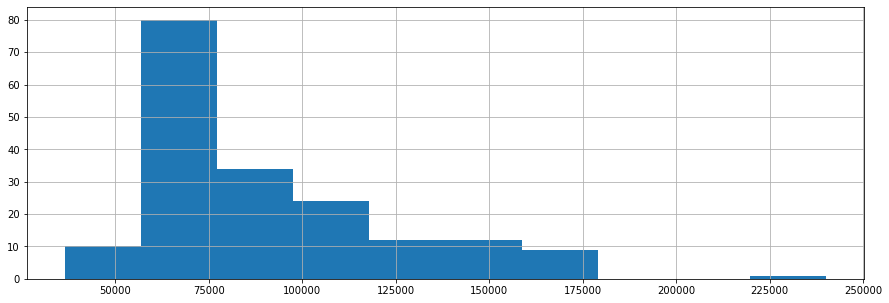

In [43]:
# set target
target = 'construction_value'
#remove zeros....
results_df=results_df[results_df[target]>25000]
#baseline estimation off the top for regression
results_df[target].mean()
results_df[target].hist()

#there are outliers -let's take a closer look construction_Values over $20k

In [44]:
outliers=results_df[results_df[target]>200000]
outliers.describe()

,year,month_number,construction_value,floor_area,units_added,neighbourhood_numberr,latitude,longitude
count,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000
mean,2018.0,9.0,240000.0,840.0,1.0,3450.0,53.567406,113.561844
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2018.0,9.0,240000.0,840.0,1.0,3450.0,53.567406,113.561844
25%,2018.0,9.0,240000.0,840.0,1.0,3450.0,53.567406,113.561844
50%,2018.0,9.0,240000.0,840.0,1.0,3450.0,53.567406,113.561844
75%,2018.0,9.0,240000.0,840.0,1.0,3450.0,53.567406,113.561844
max,2018.0,9.0,240000.0,840.0,1.0,3450.0,53.567406,113.561844


##there's a single Garden Suite Build over $200k in 2018. I remove this outlier from the dataset.I also remove the single build in 2011 as it skews the set. The next year one was built is 2018 actually.

In [45]:
results_df=results_df[results_df[target]<200000]
results_df=results_df[results_df['year']>2017]


#Normalize construction_value to 2022 dollars.
###Before we look more at our regression target, take into account time value of money to adjust the construction_value to the todays dollars. I could import numpy financial libraries but I instead build the function below.

In [46]:
yr_map = {2018:4, 2019:3, 2020:2, 2021:1, 2022:0}
#map year to to column
results_df["yr_no"] = results_df["year"].map(yr_map).fillna("Other")

In [47]:
#r is average interest rate for 5 year fixed rate between 2017 and 2022. Cheap money!
r=0.05
results_df[target] = results_df[target] *(1.0 + r)**results_df['yr_no']
results_df.drop(columns={"yr_no", "year"}, inplace=True)

In [48]:
to_scale.pop(0)

'year'

<AxesSubplot:>

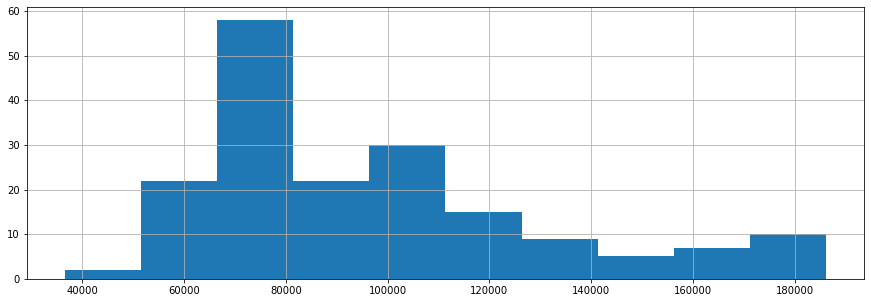

In [49]:
results_df[target].hist()

In [50]:
results_df.head()

,month_number,construction_value,floor_area,units_added,neighbourhood_numberr,latitude,longitude
0,9.0,115021.620000,864.0,1.0,5580.0,53.523739,113.532990
1,9.0,71489.131875,537.0,1.0,4290.0,53.555435,113.592476
2,6.0,42997.500000,325.0,1.0,5290.0,53.513481,113.526848
3,1.0,75818.925000,598.0,1.0,5290.0,53.508739,113.520187
5,9.0,89461.260000,672.0,1.0,3200.0,53.545464,113.550064


#A simple statistical look at our mean and standard deviation, after these many cleaning steps can give a first glimpse into reasonable Garden Suite construction costs....



In [51]:
results_df.agg({'construction_value': ['count', 'mean', 'std', 'min', 'max', 'nunique'],
        'floor_area': ['count', 'mean', 'std', 'min', 'max', 'nunique']})

,construction_value,floor_area
count,180.000000,180.000000
mean,96873.856857,754.133362
std,33833.678294,267.319061
min,36600.000000,305.000000
max,186111.371250,1462.000000
nunique,163.000000,139.000000


It is approximately $97000+-$67k for 95% of builds (2 stds) for floor area 750 sq ft +- 500 sq ft. 

#Look at target visually with a kde plot - kernel desnity estimation of a histogram. This is a continuous probability density curve. The question we are asking is, is this a normal distribution?

<AxesSubplot:xlabel='construction_value', ylabel='Density'>

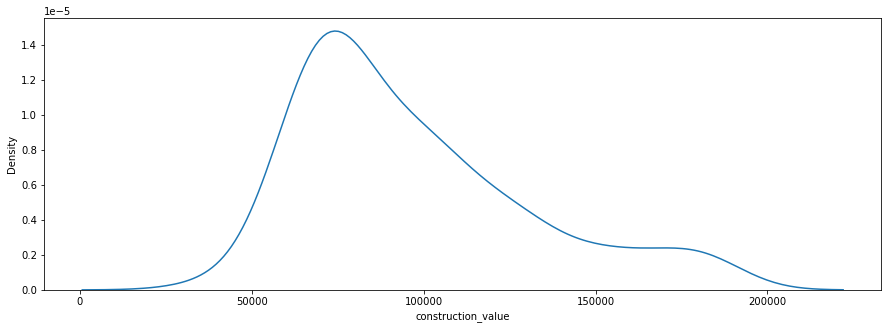

In [52]:
tmp = results_df[target]
tmp1 = np.log(results_df[target])

#Raw values show heavy right tail....
sns.kdeplot(data=tmp)

<AxesSubplot:xlabel='construction_value', ylabel='Density'>

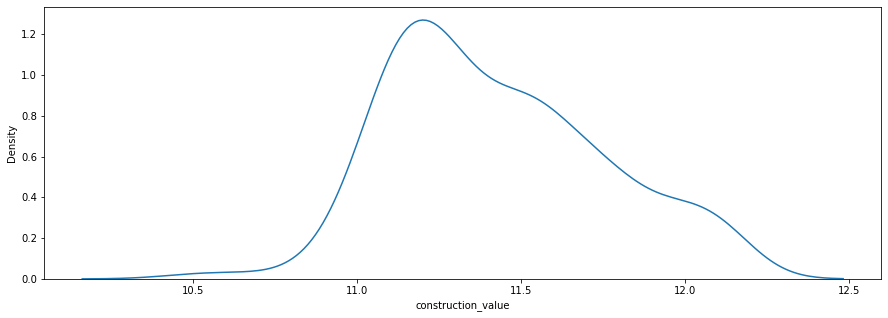

In [53]:
#Logged values
sns.kdeplot(data=tmp1)

#Let's check if Construction_value is normally distributed analytically....

In [54]:

def normaldist(df, col=target, alpha=.05):
# Check Normality with code, k2 is kertosis measure, p is skew
    tmp = df[col]
    k2, p = ss.normaltest(tmp)  # check kertosis and skew
# If we were to write out our decision....
    alpha = alpha
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        return print("The null hypothesis, col comes from a normal distriution, can be rejected")
    else:
        return print("The null hypothesis, col comes from a normal distriution, cannot be rejected")

normaldist(results_df, target, alpha=.05)

The null hypothesis, col comes from a normal distriution, can be rejected


####This is very interesting, depending on the data we draw the results are sometimes normally distributed and sometimes not, within a reasonable doubt (19/20) even though visually we see a thicker right tail in the distribution on most samples. I'm not going to log transform this target.

array([[<AxesSubplot:title={'center':'month_number'}>,
        <AxesSubplot:title={'center':'construction_value'}>,
        <AxesSubplot:title={'center':'floor_area'}>],
       [<AxesSubplot:title={'center':'units_added'}>,
        <AxesSubplot:title={'center':'neighbourhood_numberr'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'longitude'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

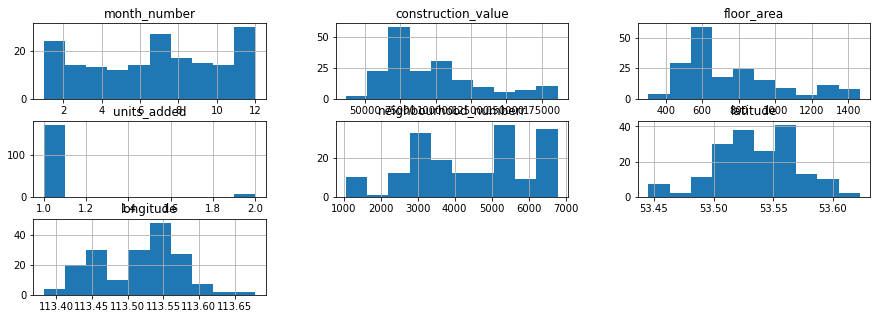

In [55]:
results_df.hist()

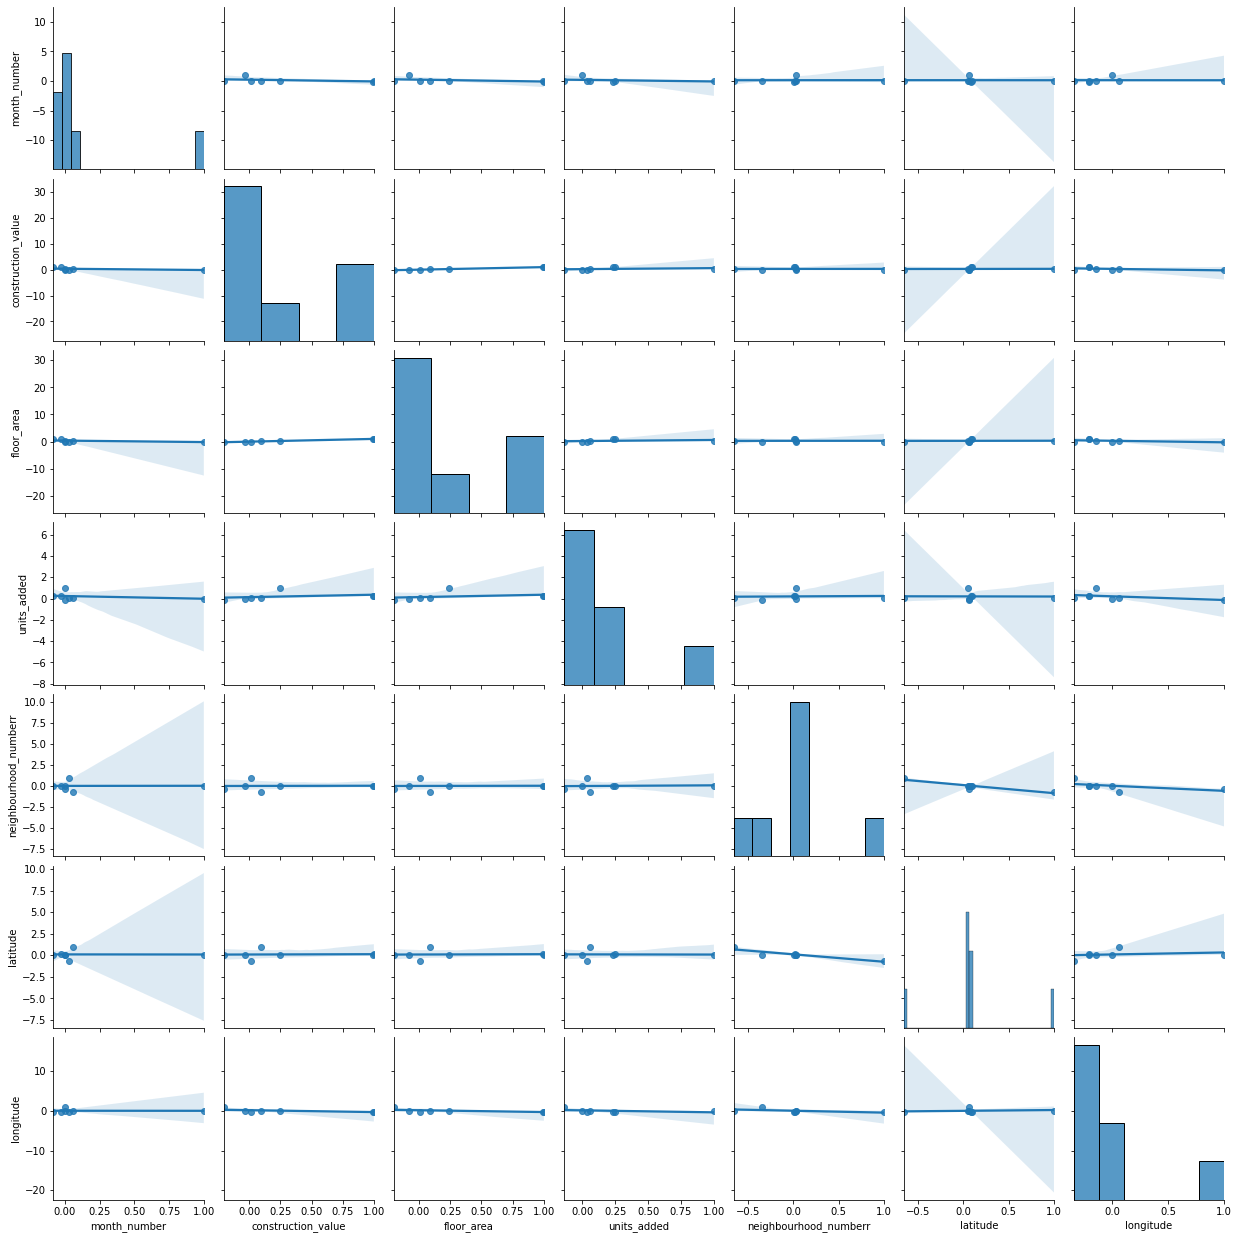

In [56]:
# use pandas
df1 = results_df.corr()
sns.pairplot(df1, dropna=True, kind='reg')
plt.show()

In [57]:
#we have massive correlations, esp with floor_area
df1.style.background_gradient()
df1.style.background_gradient().set_precision(2)

,month_number,construction_value,floor_area,units_added,neighbourhood_numberr,latitude,longitude
month_number,1.00,-0.03,-0.08,-0.00,0.03,0.06,-0.00
construction_value,-0.03,1.00,0.99,0.25,0.01,0.09,-0.21
floor_area,-0.08,0.99,1.00,0.24,0.01,0.09,-0.20
units_added,-0.00,0.25,0.24,1.00,0.03,0.05,-0.14
neighbourhood_numberr,0.03,0.01,0.01,0.03,1.00,-0.66,-0.35
latitude,0.06,0.09,0.09,0.05,-0.66,1.00,0.06
longitude,-0.00,-0.21,-0.20,-0.14,-0.35,0.06,1.00


 Construction Values are highly correlated with floor_area. Based on the pairplot I suspect a simple formula using linear regression to figure out what the city of edmonton values these jobs at per square foot. I am now suspicious of my data and check the permitting process. Indeed, there is no feild to input construction_value and it is determined using a formula by the city. Let's figure our what this rate is....

In [58]:

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#Split data as normal
y = results_df[target]
X = results_df.drop(columns={target})

#Build pipeline
#Linear regression is my model of choice as it most simplifies decision making.
model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# The pipeline is our estimator and avoids leaking the test set into the train set
model.fit(X_train, y_train)
cvs = cross_val_score(model, X_train, y_train.ravel(), cv=5)
print('Training CrossVal Score:', cvs)
print("Average Train Score:", np.mean(cvs))
print('Testing score:', model.score(X_test, y_test))

Training CrossVal Score: [0.99221902 0.98927452 0.99025083 0.98838725 0.98255765]
Average Train Score: 0.9885378528115852
Testing score: 0.9842341372801762


Here is our model!

In [59]:
print("Intercept: ", model.intercept_)
print("Coefficients: " ,model.coef_)

Intercept:  -243502.2
Coefficients:  [ 5.4668488e+02  1.2561500e+02  1.8314569e+03  3.3368301e-01
 -1.5212617e+03  2.8175439e+03]


We've got this one in the bag. Over 99% testing accuracy.

In [60]:
#Scale ALL the data
df_ = results_df.drop(columns={"construction_value"})

In [61]:
import statsmodels.api as sm
X2 = sm.add_constant(df_)
est = sm.OLS(y,X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:     construction_value   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2817.
Date:                Tue, 02 Aug 2022   Prob (F-statistic):          1.18e-169
Time:                        15:02:15   Log-Likelihood:                -1718.9
No. Observations:                 180   AIC:                             3452.
Df Residuals:                     173   BIC:                             3474.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.525e+

With P>|t| WAY greater than .05 I determine the last 4 variable in the set are adding nothing to the regression. I drop them. 

In [62]:
df = results_df[[ "month_number", "floor_area" ]]

In [63]:
import statsmodels.api as sm
X3 = sm.add_constant(df)
est = sm.OLS(y,X3)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     construction_value   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     8519.
Date:                Tue, 02 Aug 2022   Prob (F-statistic):          1.17e-176
Time:                        15:02:15   Log-Likelihood:                -1720.2
No. Observations:                 180   AIC:                             3446.
Df Residuals:                     177   BIC:                             3456.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1967.0487    975.630     -2.016   

#Garden_Suite_construction_value= -1967.0487 + 532.7971(month_of_permit) + 126.2888(floor_area)

The model has an R2 of 99%. This means 99% of the price of garden suite construction values are explainable by the month the permit was pulled in and the floor_area of the Garden Suite.

#Run the estimate function below. Be sure to input your own metrics....

In [94]:
def readIntBetween(low, high, var_text) :
   value = float(input("Enter a " + str(var_text) + " number between " + str(low) + " and " + 
                      str(high) + ": "))
   while value < low or value > high :
        print("Error: value out of range.")
        value = float(input("Enter a value between " + str(low) + " and " + 
                    str(high) + ": "))
   return value
months = float(readIntBetween(1, 12, 'month'))
sq_ft = float(readIntBetween(300, 1500, 'floor area in square feet that is a'))
print("You entered month number %d, and %d square feet." % (months, sq_ft))
garden_suite_construction_value= 532.79*months + 126.28*sq_ft-1967.04
print("Garden Suite Construction Value estimate:  $",garden_suite_construction_value)

You entered month number 5, and 1200 square feet.
Garden Suite Construction Value estimate:  $ 152232.91
